# Object Detection I: Training

In this session we will train an SSD model using Pascal VOC data. SSD was introduced in the paper:

Liu et al. [SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf). ECCV 2016


SSD is an unified framework for object detection with a single network. The original implementation in Caffe can be found [here](https://github.com/weiliu89/caffe/tree/ssd). In this example we will use [an implementation](https://github.com/rykov8/ssd_keras) in keras and tensorflow.

<img src="../figs/ssd_overview.PNG">

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
import numpy as np
import pickle
from ssd import SSD300
from ssd_utils import BBoxUtility, Generator

SEED = 4242
np.random.seed(SEED)

Using TensorFlow backend.


Load the anchor bounding boxes and initialize the bounding box utilities:

In [3]:
NUM_CLASSES = 21
input_shape = (300, 300, 3)
nms_thresh = 0.4
priors = pickle.load(open('../data/files/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors, nms_thresh = nms_thresh)

Let's look at the anchor boxes:

In [4]:
print(np.shape(priors))
print (priors[0])

(7308, 8)
[ 0.          0.          0.06315789  0.06315789  0.1         0.1         0.2
  0.2       ]


priors[i] = [xmin, ymin, xmax, ymax, varxc, varyc, varw, varh]

Create training file based on PASCAL VOC data. This will put all the information (i.e. box coordinates, categories and image paths) into a single file:

In [5]:
import os
pascal_gt = '../data/files/VOC2007.pkl'
if not os.path.isfile(pascal_gt):
    from PASCAL_VOC.get_data_from_XML import XML_preprocessor
    data = XML_preprocessor('../../../../data/VOCdevkit/VOC2007/Annotations/').data
    pickle.dump(data,open(pascal_gt,'wb'))

We load the annotations file:

In [6]:
gt = pickle.load(open('../data/files/VOC2007.pkl', 'rb'))

Let's take a peek at this file:

In [7]:
key1 = gt.keys()[0]
print (key1)
print (gt[key1][0])

007777.jpg
[ 0.004       0.52406417  0.74        1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


The first 4 positions are the coordinates of the bounding box, and the remaining ones compose the one-hot vector representing the category. Let's now split the dataset between training and validation.

In [8]:
train_perc = 0.8
keys = sorted(gt.keys())

num_train = int(round(train_perc * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

Initialize the generator. Here we must indicate the path where the raw jpeg files are stored and the batch size we want to use:

In [9]:
path_prefix = '../../../../data/VOCdevkit/VOC2007/JPEGImages/'
batch_size = 64
gen = Generator(gt, bbox_util, batch_size, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [10]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)

Callbacks in keras are functions that are applied at some points during the training procedure. We will use the one called ```ModelCheckpoint``` which will save the model after every epoch only if it improves validation performance.

In [11]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('../data/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                    verbose=2,save_weights_only=True,monitor='val_loss')

We define the optimizer and compile the model. Notice we use a custom loss here ```MultiboxLoss```. We will take a look at this loss in depth later, but for now let's move on until we have our model training. Since it will take a while, it will give us some time to review technical details.

In [12]:
from keras.optimizers import Adam
from ssd_training import MultiboxLoss

base_lr = 1e-3
optim = Adam(lr=base_lr)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

We start training the model here. We will only do 2 epochs to be able to see some intermediate outputs.

In [13]:
nb_epoch = 2
# 1 epoch - 500s running on titanX or K80 GPU (batch size 64)
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=2,
                              callbacks=[mc],
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2


/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to ../data/checkpoints/weights.00-4.08.hdf5
504s - loss: 5.2879 - val_loss: 4.0808
Epoch 2/2
Epoch 00001: saving model to ../data/checkpoints/weights.01-3.58.hdf5
483s - loss: 3.7594 - val_loss: 3.5790


Once it finishes the 2 epochs, run it again for longer. We will see the performance of the model in the next lab session.

### While we are waiting...

#### 1. Loss function
As a reminder, the loss used to train this model is defined with the following equations. First, we have that the loss is a combination of the detection loss ($L_{loc}$) and classification loss ($L_{conf}$).

<img src="../figs/total_loss.PNG">

Let's see the two loss components:

<img src="../figs/loc_loss.PNG" style="width: 600px;"/>

<img src="../figs/smoothl1.PNG">

$L_{loc}$ is defined as the smooth L1 distance between parameterized box coordinates. Notice that $L_{loc}$ is only computed for positive classes. Boxes that are labeled as background do not contribute to the loss at all.  $g$ and $l$ are the ground truth and predicted bounding box coordinates. See how box coordinates are regressed to offsets wrt anchor boxes $d$ in the equations above. $x$ gives the matching pairs between ground truth and predicted boxes, which is obtained by selecting the pairs with an IoU over a certain threshold. You can check the implementation of $L_{loc}$ in ```ssd_training.py```.

$L_{conf}$ is the multiclass softmax loss. Check the implementation in ```ssd_training.py```.

<img src="../figs/class_loss.PNG">

Finally, let's check the implementation of total loss computation in ```ssd_training.py``` to see how these two are combined.

#### 2. Model architecture

In the paper, the authors give the following figure for the model architecture:

<img src="../figs/ssd_arch.PNG">

Now let's look at ```ssd.py``` to see how this is implemented in keras.

Once training has finished, we can take a look at some of the predictions that the model is able to make for some of our images. First we define a function to display boxes above a certain threshold.

In [18]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']

def display_boxes(img,preds,th):
    # Parse the outputs.
    det_label = preds[:, 0]
    det_conf = preds[:, 1]
    det_xmin = preds[:, 2]
    det_ymin = preds[:, 3]
    det_xmax = preds[:, 4]
    det_ymax = preds[:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= score_thresh]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    plt.axis('off')
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

Now let's take a few validation images and test how it works

In [19]:
from scipy.misc import imread
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image

inputs = []
images = []

idxs = [0,2,10,15]
for idx in idxs:
    img_path = path_prefix + sorted(val_keys)[idx]
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [20]:
preds = model.predict(inputs, batch_size=1, verbose=0)
results = bbox_util.detection_out(preds)

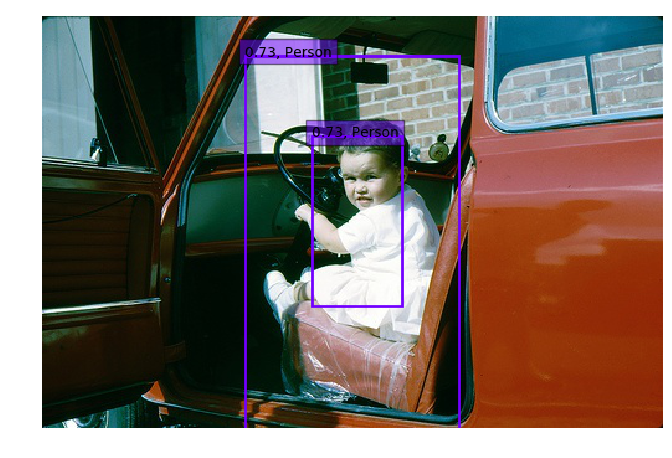

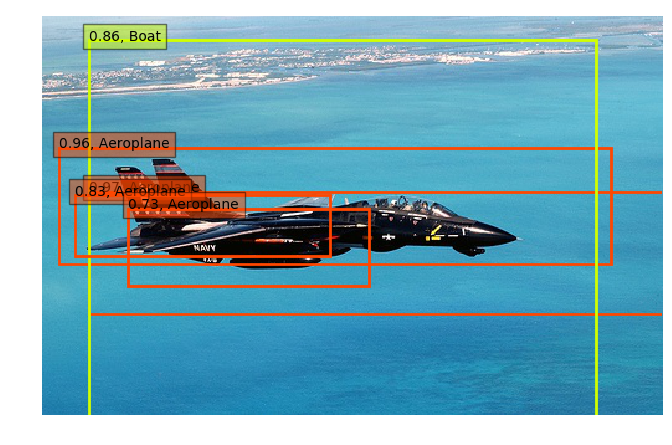

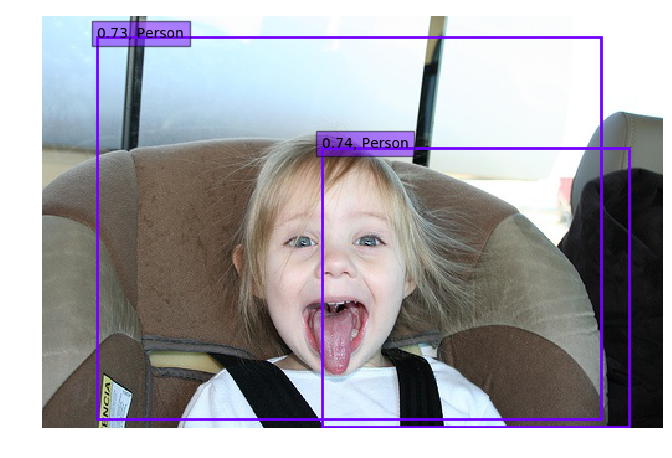

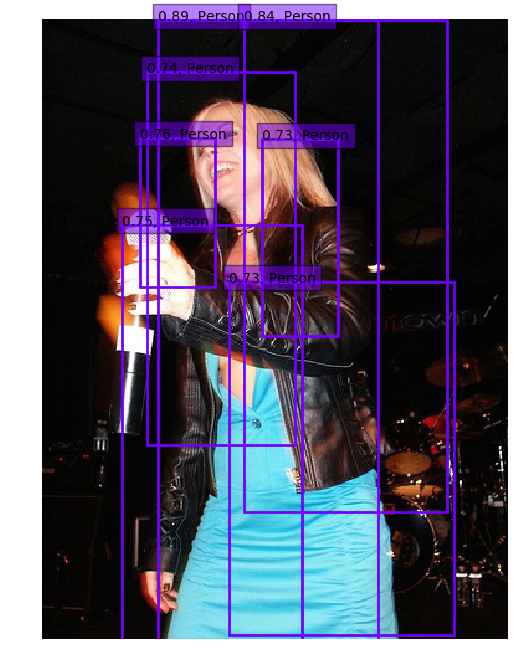

In [21]:
score_thresh = 0.7
for i, img in enumerate(images):
    display_boxes(img,results[i],score_thresh)

Results don't look very good at the moment, but we should probably train for a lot longer ! In the next lab session we will use a pretrained model and test it on some images.